<a href="https://colab.research.google.com/github/hayannn/AIFFEL_MAIN_QUEST/blob/main/Reuters_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터셋 정보
- Reuters 데이터셋
  - 로이터 뉴스 기사 데이터셋
  - train dataset : 8,982개
  - test dataset : 2,246개
  - 레이블 : 주제 기준 46개

<br>

## 주의사항
- 노드 10에서 진행했던 데이터셋인만큼 기존 적용 방식과 다른 형식 필요
  - 기존의 ReLU와 다른 활성화 함수 사용
  - BatchNormalization 및 Dropout 적용
  - ModelCheckpoint와 EarlyStopping 콜백 함수도 적용

<br>

# 데이터 로드 및 전처리
### 라이브러리 import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

### 데이터 로드
- keras.datasets 내장 reuters 데이터셋 사용

- 검증 데이터 기준 : 25%
- 단어 개수는 10,000개로 제한
- 데이터셋 분리 적용
- train, validate, test 데이터, 레이블 종류 확인

In [3]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
6736
2246
2246
46


### 전처리 방법
- 텍스트 데이터 ➡️ 벡터 변환
  - 원-핫 인코딩 사용
- 레이블(뉴스 주제)도 동일하게 변환

In [5]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, sequence in enumerate(data):
        results[i, sequence] = 1
    return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

<br>

# 모델 구성 및 컴파일
- 더 다양한 텍스트 패턴을 볼 수 있도록 활성화 함수를 ELU로 설정
- BatchNormalization, Dropout 적용
  - 빠른 학습 및 overfitting 방지
  - 드롭아웃은 50%로 설정!

In [8]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성

# 모델 구성
model = models.Sequential()

# input layer
model.add(layers.Dense(512, activation='elu', input_shape=(10000,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# hidden layer
model.add(layers.Dense(512, activation='elu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# output layer(뉴스 주제가 46개이므로, 클래스는 46개)
model.add(layers.Dense(46, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 512)                 │       5,120,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 46)                  │          23,598 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,410,862 (20.64 MB)

 Trainable params: 5,408,814 (20.63 MB)

 Non-trainable params: 2,048 (8.00 KB)

<br>

# 모델 학습
- ModelCheckpoint, EarlyStopping 콜백 함수 적용

### ModelCheckpoint
#### 🚀troubleshooting
- 버전업으로 인해 파일명 끝에 `.keras`가 있어야 함!

In [10]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint_cb = ModelCheckpoint('best_model.h5',
#                                 monitor='val_loss',
#                                 save_best_only=True,
#                                 mode='min',
#                                 verbose=1)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint('best_model.h5.keras',
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min',
                                verbose=1)

### EarlyStopping
- 기준 : epochs 3개까지 개선되지 않으면 종료
- 종류 후에 최적 모델 가중치 복원 설정

In [12]:
early_stopping_cb = EarlyStopping(monitor='val_loss',
                                  patience=3,
                                  restore_best_weights=True,
                                  verbose=1)

### 모델 학습

In [13]:
history = model.fit(x_train,
                    y_train,
                    epochs=60,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5307 - loss: 2.5689
Epoch 1: val_loss improved from inf to 1.74506, saving model to best_model.h5.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.5332 - loss: 2.5558 - val_accuracy: 0.7947 - val_loss: 1.7451
Epoch 2/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8588 - loss: 0.7028
Epoch 2: val_loss improved from 1.74506 to 1.26996, saving model to best_model.h5.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8589 - loss: 0.7022 - val_accuracy: 0.8108 - val_loss: 1.2700
Epoch 3/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9238 - loss: 0.3714
Epoch 3: val_loss improved from 1.26996 to 1.07202, saving model to best_model.h5.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.9237 - loss: 0.3715 - val_accuracy: 0.8090 - val_loss: 1.0720
Epoch 4/60
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9488 - loss: 0.2480
Epoch 4: val_loss improved from 1.07202 to 

### 결과 시각화

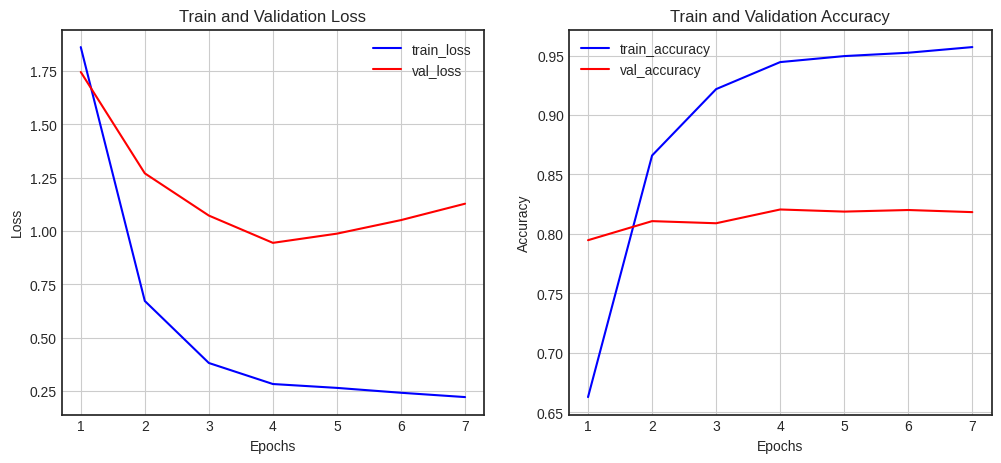

In [14]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화
plt.style.use('seaborn-v0_8-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

<br>

# 모델 평가 및 예측
- 노드 10에서의 accuracy : 0.7845
- 현재 accuracy : 0.7898

In [17]:
# 모델 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# 모델 예측
predictions = model.predict(x_test)

# 예측 결과 중 3개만 출력해보기
print("Predictions (first 5 samples):")
print(predictions[:3])

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8001 - loss: 0.9842
Test Loss: 1.0329139232635498
Test Accuracy: 0.7898486256599426
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Predictions (first 5 samples):
[[1.1378442e-03 2.2338734e-04 7.0412143e-04 9.3548959e-01 5.3334264e-03
  5.3908920e-04 2.1738070e-03 2.4972677e-03 3.2344069e-03 2.4462794e-03
  6.7102158e-04 1.1016282e-03 1.5385968e-03 7.2962797e-04 7.7789207e-04
  9.8876527e-04 1.7933371e-03 3.9713664e-04 1.0223200e-03 5.7156052e-04
  3.1355093e-03 3.5702831e-03 9.5881126e-04 1.8212976e-03 2.9468097e-04
  9.7908580e-04 5.6454155e-04 1.1107243e-03 2.5874504e-03 1.7132651e-03
  2.1988975e-03 6.4062676e-04 2.0212184e-03 3.6875316e-04 1.4269431e-03
  6.1626278e-04 2.0702039e-03 1.2601240e-03 2.3938734e-03 2.1802764e-03
  1.6211790e-03 7.3597633e-04 5.1141891e-04 4.3436003e-04 6.5426546e-04
  7.5884030e-04]
 [4.1203019e-03 6.3080713e-02 8.6035617e-03 6.4649038e-07 3.5539195e-03
  3.2945458e-02 1.4865076e-02 2.4817907e-03 8.6382445e

# 추가 - 모델 예측 결과 시각화(confusion matrix)

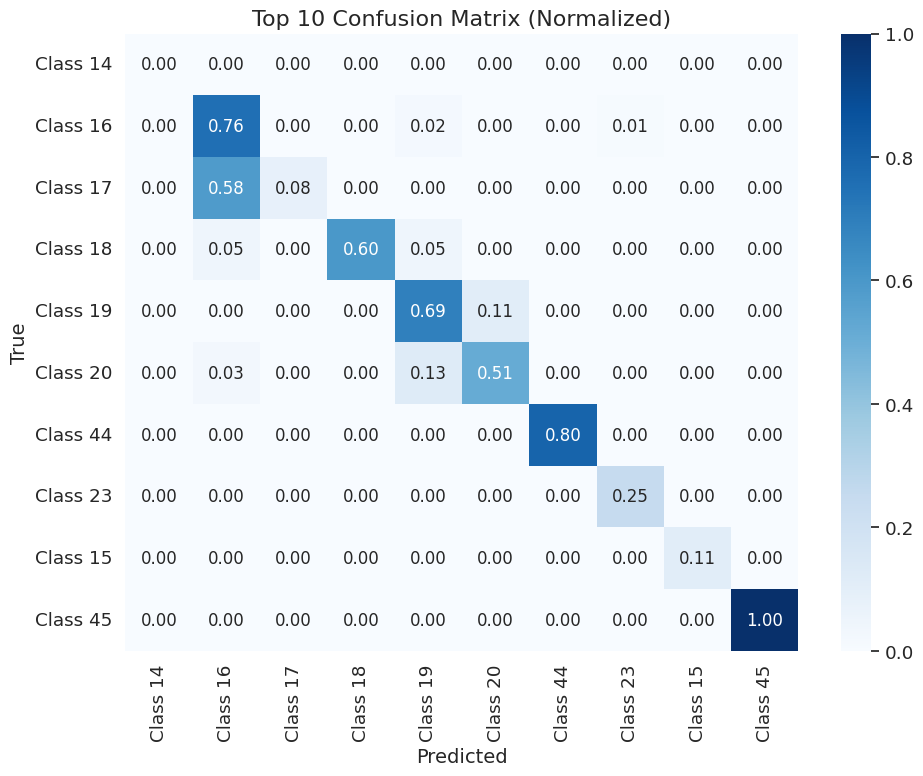

In [25]:
predicted_classes = predictions.argmax(axis=1)

true_classes = y_test.argmax(axis=1)

cm = confusion_matrix(true_classes, predicted_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

class_names = [f"Class {i}" for i in range(46)]

# 각 클래스에서 가장 큰 오차율을 가진 상위 10개 클래스
error_rates = np.sum(cm_normalized, axis=1)
top_10_classes = np.argsort(error_rates)[-10:]
cm_selected = cm_normalized[np.ix_(top_10_classes, top_10_classes)]
class_names_selected = [class_names[i] for i in top_10_classes]

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
heatmap = sns.heatmap(cm_selected, annot=True, fmt='.2f', cmap='Blues', cbar=True,
                      xticklabels=class_names_selected, yticklabels=class_names_selected, annot_kws={"size": 12})

plt.title('Top 10 Confusion Matrix (Normalized)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

plt.tight_layout()
plt.show()

<br>

# 회고
이번 데이터셋은 로이터 뉴스기사 데이터셋이었고, 텍스트 데이터였기 때문에 전처리 과정에서 원-핫 인코딩이 필요하여 바로 진행했습니다.
<br>
또한, 레이블 데이터도 역시 범주형 데이터 형태였기 때문에 동일하게 원-핫 인코딩을 해줬어요.
<br>
<br>
모델의 활성화 함수를 ReLU가 아닌 ELU로 변경을 했는데, 그 이유는 텍스트 데이터의 특성을 조금 더 고려할 수 있도록 음수 영역의 기울기를 가지고 있으면서도 학습 속도가 더 빠른 경우를 선택하기 위함이었습니다.
<br>
결론적으로 더 빠르게 학습하면서도 빨리 수렴될 수 있도록 하는 목적이었어요.
<br>
<br>
모델 학습 파트에서 ModelCheckpoint를 이용해서 최적 가중치를 복원할 수 있도록 설정했습니다.
<br>
또, EarlyStopping도 같이 사용해서 에폭이 3번 반복되는동안 성능이 개선되지 않을 경우, 바로 종료될 수 있도록 설정해 학습 시간이 빨라지는 것에 포커스를 맞췄던 것 같아요.
<br>
그리고 모델 평가와 예측 결과를 보고, 시각화까지 이전 프로젝트와 유사하게 진행했습니다.
<br>
다만, 딥러닝 모델의 경우 최소 85% 이상의 정확도가 나오는 것이 좋으나 그 부분을 만족하지 못한 점이 아쉬웠어요! 개선하고 싶습니다😄
